## Практическое задание

1. Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
!pip install stop-words pymorphy2
from string import punctuation
from stop_words import get_stop_words
from nltk.stem import WordNetLemmatizer, PorterStemmer
from tqdm import tqdm 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 492.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 14.6 MB/s eta 0:00:00


In [2]:
# вспомогательные функции

# функция преобразования текста
def preprocess_text(txt):
    txt = str(txt)    
    txt = ''.join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = [stemmer.stem(word) for word in txt.split() if word not in sw]
    txt = [lemmatizer.lemmatize(word) for word in txt]
    return ' '.join(txt)


# функция превращения текста в последовательность
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

## Загрузка данных

In [3]:
# зададим параметры

max_words = 3000
max_len = 30
num_classes = 1

# обучение
epochs = 10
batch_size = 256
print_batch_n = 100

In [4]:
# прочитаем данные
train_data = pd.read_csv('../input/twitter-sentiment-analysis-hatred-speech/train.csv')
test_data = pd.read_csv('../input/twitter-sentiment-analysis-hatred-speech/test.csv')

train_data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
# разделим данные на тренировочную и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_data['label'], test_size=0.2, random_state=42)
X_train.drop('label', axis=1, inplace=True)
X_valid.drop('label', axis=1, inplace=True)

In [6]:
print(f'Train shapes: {X_train.shape}, {y_train.shape}')
print(f'Valid shapes: {X_valid.shape}, {y_valid.shape}')
print(f'Test shape: {test_data.shape}')

Train shapes: (25569, 2), (25569,)
Valid shapes: (6393, 2), (6393,)
Test shape: (17197, 2)


In [7]:
# label 1 - the tweet is racist/sexist
# label 0 - the tweet is NOT racist/sexist

y_train.value_counts()

0    23783
1     1786
Name: label, dtype: int64

## Предобработка данных

In [8]:
# создадим множество стоп-слов для английского языка
sw = set(get_stop_words('en'))
# sw

In [9]:
# создадим множество с пунктуацией
puncts = set(punctuation)
# puncts

In [10]:
# сделаем стемминг (уберем лишние куски слова)
stemmer = PorterStemmer()
stemmer.stem('dysfunctional')

'dysfunct'

In [11]:
# сделаем лемматизацию
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('makes')

'make'

In [12]:
# посмотрим пример твита
X_train['tweet'].iloc[:1].values

array(["@user @user @user because i've been paying attention for the past year/8 years. he's a â\x80¦ "],
      dtype=object)

In [13]:
# твит после обработки
X_train['tweet'].iloc[:1].apply(preprocess_text).values

array(['user user user ive pay attent past year8 year he â\x80¦'],
      dtype=object)

In [14]:
# обработаем данные
tqdm.pandas()

X_train['tweet'] = X_train['tweet'].progress_apply(preprocess_text)
X_valid['tweet'] = X_valid['tweet'].progress_apply(preprocess_text)
test_data['tweet'] = test_data['tweet'].progress_apply(preprocess_text)

100%|██████████| 17197/17197 [00:04<00:00, 3521.98it/s]


In [15]:
# соединим все слова вместе
train_corpus = " ".join(X_train["tweet"])
train_corpus = train_corpus.lower()

In [16]:
# сделаем токенизацию
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['user', 'user', 'user', 'ive', 'pay']

In [17]:
# отфильтруем токены (проверим все символы, что они являются буквенно-цифровыми)
tokens_filtered = [word for word in tokens if word.isalnum()]

In [18]:
len(tokens_filtered)

214868

In [19]:
# посчитаем количество повторений каждого слова
dist = FreqDist(tokens_filtered)

# берем топ 3000
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

2999

In [20]:
tokens_filtered_top[:10]

['user', 'love', 'day', 'happi', 'u', 'amp', 'thank', 'just', 'will', 'get']

In [21]:
# составим словарь
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
# vocabulary

In [22]:
%%time

# преобразуем тексты в последовательности
X_train = np.asarray([text_to_sequence(text, max_len) for text in X_train['tweet']])
X_valid = np.asarray([text_to_sequence(text, max_len) for text in X_valid['tweet']])
test_data = np.asarray([text_to_sequence(text, max_len) for text in test_data['tweet']])

CPU times: user 8.1 s, sys: 20.3 ms, total: 8.12 s
Wall time: 8.16 s


In [23]:
X_train.shape

(25569, 30)

In [24]:
train_data['tweet'].iloc[1]

"@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked"

In [25]:
X_train[1]

array([   1,  725,  288,   48, 1975, 2804,    1,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

## Создание модели

In [26]:
# класс с архитектурой модели

class Net(nn.Module):
    
    
    def __init__(self, vocab_size=2000, embedding_dim=256, out_channel=256, num_classes=1, th=0.5):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(out_channel, num_classes)
        self.dropout = nn.Dropout(0.2)
        
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)
        output = self.dropout(output)
        
        output = torch.max(output, axis=2).values        
        
        output = self.linear_2(output)
        output = torch.sigmoid(output)
        
        return output
    
    
    def predict(self, x):
        output = self.embedding(x)     
        output = output.permute(0, 2, 1)
        
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)
        output = self.dropout(output)
        
        output = torch.max(output, axis=2).values
        
        output = self.linear_2(output)
        output = torch.sigmoid(output)
        
        output = torch.squeeze((output > th).int())
        
        return output

In [27]:
# класс для создания кастомного датасета

class DataWrapper(Dataset):
    
    
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        self.transform = transform
        if target is None:
            self.target = torch.FloatTensor([])
        else:      
            self.target = torch.from_numpy(target).long()  
        
        
        
    def __getitem__(self, index):     
        x = self.data[index]  
        
        if self.transform:
            x = self.transform(x)

        if self.target.shape[0] == 0:
            return x
        else:                
            y = self.target[index]
            return x, y

    
    def __len__(self):
        
        return len(self.data)

In [28]:
# загрузим данные для модели

train_dataset = DataWrapper(X_train, y_train.values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(X_valid, y_valid.values)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)

In [29]:
for x, l in train_loader:
    
    print(x.shape)
    print(l.shape)
    print(l[0])
    
    break

torch.Size([256, 30])
torch.Size([256])
tensor(1)


In [30]:
# проверим наличие GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [31]:
# инициализируем модель
model = Net(vocab_size=max_words)

In [32]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(3000, 256)
  (conv_1): Conv1d(256, 256, kernel_size=(2,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 899585


## Обучение модели

In [33]:
# зададим оптимизатор и критерий
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [34]:
# обучим модель

model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

Epoch [1/10]. Step [100/100]. Loss: 0.090. Acc: 0.938. Test loss: 0.272. Test acc: 0.947
Epoch [2/10]. Step [100/100]. Loss: 0.094. Acc: 0.958. Test loss: 0.002. Test acc: 0.953
Epoch [3/10]. Step [100/100]. Loss: 0.106. Acc: 0.970. Test loss: 0.001. Test acc: 0.953
Epoch [4/10]. Step [100/100]. Loss: 0.087. Acc: 0.980. Test loss: 0.001. Test acc: 0.956
Epoch [5/10]. Step [100/100]. Loss: 0.099. Acc: 0.987. Test loss: 0.012. Test acc: 0.955
Epoch [6/10]. Step [100/100]. Loss: 0.026. Acc: 0.992. Test loss: 0.001. Test acc: 0.957
Epoch [7/10]. Step [100/100]. Loss: 0.011. Acc: 0.996. Test loss: 0.000. Test acc: 0.956
Epoch [8/10]. Step [100/100]. Loss: 0.012. Acc: 0.997. Test loss: 0.000. Test acc: 0.957
Epoch [9/10]. Step [100/100]. Loss: 0.012. Acc: 0.998. Test loss: 0.012. Test acc: 0.955
Epoch [10/10]. Step [100/100]. Loss: 0.007. Acc: 0.999. Test loss: 0.000. Test acc: 0.958
Training is finished!


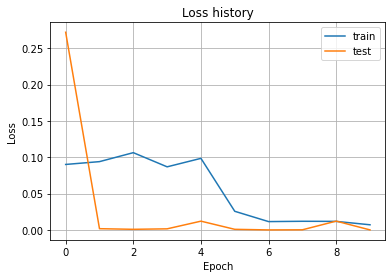

In [35]:
# визуализируем историю ошибки

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

## Предсказания на тестовых данных без разметки

In [36]:
# обработаем тестовые данные
test_samples = torch.tensor(test_data).to(device)
print(test_samples.shape)

torch.Size([17197, 30])


In [37]:
# сделаем предсказания
predictions = model.predict(test_samples)
predictions[:20]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       device='cuda:0', dtype=torch.int32)

## Вывод:


С помощью итоговой модели удалось достичь точности на трейне около **0.998**, на валидации около - **0.957**.

Точность повысилась благодаря увеличению количества топ-слов, количества слов в последовательности. Были убраны 1 конвалюционный слой и 1 плотный слой, при этом точность даже улучшилась. Был добавлен слой Dropout, который совсем чуть-чуть затормозил переобучение. Также был уменьшен шаг обучения.